In [1]:
import geopandas as gpd
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

data = './data'

In [4]:
def gini_JP(temp_df, var_x, var_y):
    '''
    input: 
    temp_df: DataFrame that has at least two columns 
    var_x: varaible which denotes number of locations, population or confirmed COVID-19 cases
    var_y: variable which denotes accessibility
    
    output: 
    gini_coef: Gini coefficient
    x_: cumulative distribution of locations, population or confirmed COVID-19 cases
    y_: cumulative distribution of accessibility 
    
    '''
    
    # Sort dataframe based on the accessibility
    temp_df = temp_df.copy(deep=True)
    temp_df.sort_values(by=var_y, inplace=True)
    
    # Calculate cumulative distribution of accessibility 
    y_ = temp_df[var_y].cumsum() / temp_df[var_y].sum()
    y_ = y_.to_numpy()
    
    # Calculate cumulative distribution of locations, population or confirmed COVID-19 cases
    if var_x == 'locations':
        x_ = np.ones(temp_df.shape[0]).cumsum() / np.ones(temp_df.shape[0]).sum() 

    else:
        x_ = temp_df[var_x].cumsum() / temp_df[var_x].sum()
        x_ = x_.to_numpy()
    
    # Insert value 0 at the beginning of both array to faciliate the calculation of area drawn from Lorenz curve
    x_ = np.insert(x_, 0, 0, axis=0)
    y_ = np.insert(y_, 0, 0, axis=0)
    
    # Calculate area below Lorenz curve
    area_ = 0.0
    for i in range(1, len(x_)):
        area_ += (x_[i] - x_[i-1]) * (y_[i] + y_[i-1]) / 2. # Calculate area of parallelogram

    gini_coef = (0.5 - area_) / 0.5
        
    return gini_coef, x_, y_

# Gini Index for Static Measurements

In [93]:
# Caclulate covid-19 cases per census tract
d_val = pd.read_csv('./data/reference_data/covid_data/daily_covid_case.csv')
d_val.set_index('County', inplace=True)
d_val = d_val.sum(axis=1)
d_val = pd.DataFrame(d_val, columns=['cases_county'])

d_loc = gpd.read_file('./data/reference_data/geographic_units/tract_reference.shp')
d_loc.set_index('County', inplace=True)
d_loc = d_loc.merge(d_val, left_index=True, right_index=True)
d_loc['cases_tract'] = d_loc['pop_ratio'] * d_loc['cases_county']
d_loc.reset_index(inplace=True)
d_loc.head(1)

,County,TSA,GEOID,pop,pop_ratio,geometry,cases_county,cases_tract
0,Anderson,G,48001950100,4844,0.083792,"POLYGON ((1405776.557 1097438.688, 1405779.438...",5877.0,492.444006


In [97]:
access_tract_s = gpd.read_file(os.path.join(data, 'access/ICU_access_measures/static_measurement/ICU_access_tract_static.shp'))
access_tract_s = access_tract_s.merge(d_loc[['GEOID', 'cases_tract']], on='GEOID')
access_tract_s.head(1)

,GEOID,County,TSA,pop,access,geometry,cases_tract
0,48001950100,Anderson,G,4844,0.00281,"POLYGON ((1405776.557 1097438.688, 1405779.438...",492.444006


In [116]:
# Gini Index for static measurements

# Accessibility vs Location counts
gini_static_access_location = gini_JP(access_tract_s, 'locations', 'access')
print(f'Gini Index for Locations: {gini_static_access_location[0]}')

# Accessibility vs Population
gini_static_access_pop = gini_JP(access_tract_s, 'pop', 'access')
print(f'Gini Index for Population: {gini_static_access_pop[0]}')

# Accessibility vs Confirmed cases
gini_static_access_cases = gini_JP(access_tract_s, 'cases_tract', 'access')
print(f'Gini Index for Cases: {gini_static_access_cases[0]}')



Gini Index for Locations: 0.30119920654987486
Gini Index for Population: 0.3470414973277609
Gini Index for Cases: 0.37190116663735073


# Gini Index for Dynamic Measurements

## Define sampled week

In [2]:
from_date = '07/01/2020'
to_date = '12/31/2021'

start_date = datetime.datetime.strptime(from_date,  "%m/%d/%Y")
end_date = datetime.datetime.strptime(to_date,  "%m/%d/%Y")

focus_date = []
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    focus_date.append(start_date.strftime("%m/%d/%Y"))
    start_date += delta
    
# Make a dictionary that has keys as target date and values as the date that should be averaged. 
focus_date_dict = {}
# time_delta = [3, 2, 1, 0, -1, -2, -3]
time_delta = range(7)

for idx, date in enumerate(focus_date):
    
    if datetime.datetime.strptime(date,  "%m/%d/%Y").weekday() == 0:
    
        temp_list = []
        for delta in time_delta:
            temp_list.append(
                str(
                    (datetime.datetime.strptime(focus_date[idx], "%m/%d/%Y") + datetime.timedelta(days=delta)
                    ).strftime("%m/%d/%Y"))
            )

        focus_date_dict[date] = temp_list
    
# Manually enter the dates that would have missing values
focus_date_dict['07/01/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020', '07/05/2020']
focus_date_dict['12/27/2021'] = ['12/27/2021', '12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
# focus_date_dict.keys()

In [3]:
# Measured accessibility to ICU beds per census tract
access_tract_d = gpd.read_file(os.path.join(data, 'access/ICU_access_measures/ICU_access_tract.shp'))
tract = gpd.read_file(os.path.join(data, 'reference_data', 'geographic_units', 'tract_reference.shp'))
access_tract_d = access_tract_d.merge(tract[['TSA', 'GEOID', 'County', 'pop']], on='GEOID')
access_tract_d.sort_values(by='GEOID', inplace=True, ignore_index=True)

# Replace accessibility to 1 if the value is greater than 1
access_tract_d[focus_date] = access_tract_d[focus_date].mask(access_tract_d[focus_date] > 1, 1)

access_tract_d.head(3)

,GEOID,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,06/09/2020,...,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry,TSA,County,pop
0,48001950100,0.636676,0.566900,0.565632,0.329403,0.260474,0.262326,0.260252,0.251541,0.208287,...,0.027885,0.024680,0.022385,0.019416,0.017932,0.016549,"POLYGON ((1405776.557 1097438.688, 1405779.438...",G,Anderson,4844
1,48001950401,0.120838,0.073134,0.075418,0.049090,0.042740,0.043147,0.042879,0.041804,0.037944,...,0.011066,0.009805,0.008983,0.007605,0.007031,0.006406,"POLYGON ((1392461.585 1072740.298, 1392447.163...",G,Anderson,4838
2,48001950402,0.085996,0.055994,0.057200,0.035914,0.030953,0.031189,0.030959,0.030123,0.027099,...,0.006884,0.006104,0.005574,0.004738,0.004376,0.004004,"POLYGON ((1379516.856 1075774.243, 1379519.198...",G,Anderson,7511


In [7]:
# Accumulated confirmed COVID-19 cases per census tract (which was input file for accessibility measurements)
accum_case = gpd.read_file('/Users/jparkgeo/Git_Repo/ST_ICU_Access/data/access/input_files/accumulated_covid_case_per_tract.shp')
accum_case.head(1)

,GEOID,FIPS,CTID,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,...,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry
0,48439121609,48439,21609,3.37338,3.264022,3.271528,4.139577,4.45667,4.36444,4.253899,...,13.751982,14.887925,16.67217,17.23985,19.739307,21.037272,22.025386,23.291493,25.982766,"POLYGON ((-97.23369 32.67175, -97.23366 32.671..."


In [51]:
# 7-days averaged confiremd COVID-19 cases
ave_case = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'averaged_covid_case.csv'))
ave_case_ary = ave_case[focus_date].sum().to_numpy()

In [62]:
gini_pop_list = []
gini_loc_list = []
gini_case_list = []

# for date in focus_date_dict.keys():
for date in tqdm(focus_date):
    
    # Accessibility vs Population (2 variables)
    temp_gini_pop = gini_JP(access_tract_d, 'pop', date)
    gini_pop_list.append(temp_gini_pop[0])
    
    # Accessibility vs Location counts (1 variable)
    temp_gini_loc = gini_JP(access_tract_d, 'locations', date)
    gini_loc_list.append(temp_gini_loc[0])
    
    # Accessibility vs Confirmed cases (2 variables)
    access_tract_d_ = access_tract_d.filter(['GEOID', date])
    access_tract_d_.rename(columns={date: 'access'}, inplace=True)
    
    accum_case_ = accum_case.filter(['GEOID', date])
    accum_case_.rename(columns={date: 'cases'}, inplace=True)
    
    access_case_df = access_tract_d_.merge(accum_case_, on='GEOID')

    temp_gini_case = gini_JP(access_case_df, 'cases', 'access')
    gini_case_list.append(temp_gini_case[0])
    

100%|███████████████████████████████████████████████| 549/549 [00:15<00:00, 35.72it/s]


Gini Index of Static Accessibility for Locations: 0.30119920654987486
Gini Index of Dynamic Accessibility for Location:
Max Gini of 0.71 on 07/02/2020
Min Gini of 0.411 on 06/03/2021
----------
Gini Index of Static Accessibility  for Population: 0.3470414973277609
Gini Index of Dynamic Accessibility for Population:
Max Gini of 0.743 on 07/02/2020
Min Gini of 0.44 on 10/15/2020
----------
Gini Index of Static Accessibility  for Cases: 0.37190116663735073
Gini Index of Dynamic Accessibility for Cases:
Max Gini of 0.843 on 07/05/2020
Min Gini of 0.542 on 06/03/2021


/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_37984/697925057.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)


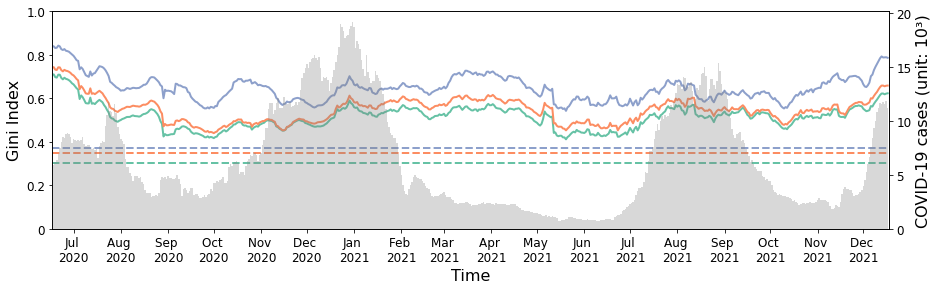

In [180]:
fig, ax = plt.subplots(figsize=(15, 4))
plot_colors = ['#66c2a5','#fc8d62','#8da0cb']


# Accessibility vs Location counts
gini_static_access_location = gini_JP(access_tract_s, 'locations', 'access')
ax.hlines(gini_static_access_location[0], 0, len(focus_date), color=plot_colors[0], linestyle='dashed', lw=2)
print(f'Gini Index of Static Accessibility for Locations: {gini_static_access_location[0]}')

ax.plot(gini_loc_list, plot_colors[0], lw=2)
print(f'''Gini Index of Dynamic Accessibility for Location:
Max Gini of {round(max(gini_loc_list), 3)} on {focus_date[gini_loc_list.index(max(gini_loc_list))]}
Min Gini of {round(min(gini_loc_list), 3)} on {focus_date[gini_loc_list.index(min(gini_loc_list))]}''')
print("----------")

# Accessibility vs Population
gini_static_access_pop = gini_JP(access_tract_s, 'pop', 'access')
ax.hlines(gini_static_access_pop[0], 0, len(focus_date), color=plot_colors[1], linestyle='dashed', lw=2)
print(f'Gini Index of Static Accessibility  for Population: {gini_static_access_pop[0]}')

ax.plot(gini_pop_list, color=plot_colors[1], lw=2)
print(f'''Gini Index of Dynamic Accessibility for Population:
Max Gini of {round(max(gini_pop_list), 3)} on {focus_date[gini_pop_list.index(max(gini_pop_list))]}
Min Gini of {round(min(gini_pop_list), 3)} on {focus_date[gini_pop_list.index(min(gini_pop_list))]}''')
print("----------")

# Accessibility vs Confirmed cases
gini_static_access_cases = gini_JP(access_tract_s, 'cases_tract', 'access')
ax.hlines(gini_static_access_cases[0], 0, len(focus_date), color=plot_colors[2], linestyle='dashed', lw=2)
print(f'Gini Index of Static Accessibility  for Cases: {gini_static_access_cases[0]}')

ax.plot(gini_case_list, color=plot_colors[2], lw=2)
print(f'''Gini Index of Dynamic Accessibility for Cases:
Max Gini of {round(max(gini_case_list), 3)} on {focus_date[gini_case_list.index(max(gini_case_list))]}
Min Gini of {round(min(gini_case_list), 3)} on {focus_date[gini_case_list.index(min(gini_case_list))]}''')

ax2 = ax.twinx()
ax2.bar(focus_date, ave_case_ary, width=1, facecolor='grey',  alpha=0.3)

period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]

ax.set_ylim(0, 1)
ax.set_xlim(0, len(focus_date))
ax.set_xticks([focus_date.index(val) for val in period])
ax.set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in period], fontsize=12)
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

ax2.set_yticks([0, 5000, 10000, 15000, 20000])
ax2.set_yticklabels([0, 5, 10, 15, 20], fontsize=12)
# ax2.set_yticklabels([0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5])
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Gini Index', fontsize=16)
ax2.set_ylabel('COVID-19 cases (unit: 10³)', fontsize=16)

plt.show()

In [165]:
[int(item.get_text()) / 1000 for item in ax2.get_yticklabels(which='both')]

[0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5]

/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_37984/1556195918.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_37984/1556195918.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)


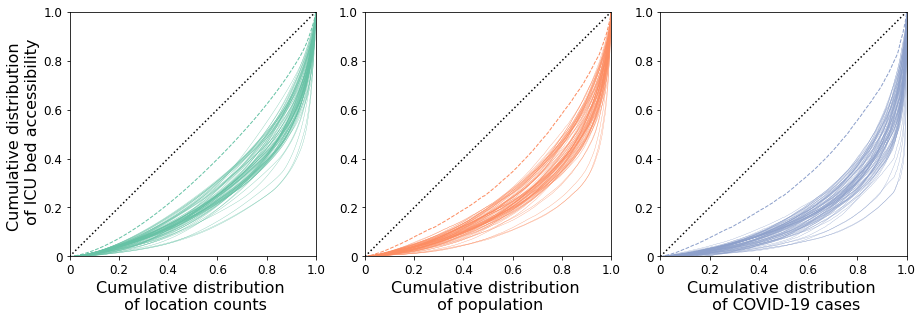

In [181]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# Static accessibility portion
gini_static_access_location = gini_JP(access_tract_s, 'locations', 'access')
axes[0].plot(gini_static_access_location[1], gini_static_access_location[2], color=plot_colors[0], linewidth=1, linestyle='dashed')

gini_static_access_pop = gini_JP(access_tract_s, 'pop', 'access')
axes[1].plot(gini_static_access_pop[1], gini_static_access_pop[2], color=plot_colors[1], linewidth=1, linestyle='dashed')

gini_static_access_cases = gini_JP(access_tract_s, 'cases_tract', 'access')
axes[2].plot(gini_static_access_cases[1], gini_static_access_cases[2], color=plot_colors[2], linewidth=1, linestyle='dashed')

for date in focus_date_dict.keys():
    # Accessibility vs Location counts (1 variable)
    temp_gini_loc = gini_JP(access_tract_d, 'locations', date)
    axes[0].plot(temp_gini_loc[1], temp_gini_loc[2], color=plot_colors[0], linewidth=0.3)
    
    # Accessibility vs Population (2 variables)
    temp_gini_pop = gini_JP(access_tract_d, 'pop', date)
    axes[1].plot(temp_gini_pop[1], temp_gini_pop[2], color=plot_colors[1], linewidth=0.3)
    
    # Accessibility vs Confirmed cases (2 variables)
    access_tract_d_ = access_tract_d.filter(['GEOID', date])
    access_tract_d_.rename(columns={date: 'access'}, inplace=True)
    
    accum_case_ = accum_case.filter(['GEOID', date])
    accum_case_.rename(columns={date: 'cases'}, inplace=True)
    
    access_case_df = access_tract_d_.merge(accum_case_, on='GEOID')

    temp_gini_case = gini_JP(access_case_df, 'cases', 'access')
    axes[2].plot(temp_gini_case[1], temp_gini_case[2], color=plot_colors[2], linewidth=0.3)
    
for i in range(3):
    # Equality line
    axes[i].plot([0,1], [0,1], color='black', linestyle='dotted')

    # Set limits of plots
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    
    axes[i].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
    axes[i].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
    

axes[0].set_ylabel('Cumulative distribution \n of ICU bed accessibility', fontsize=16)

axes[0].set_xlabel('Cumulative distribution \n of location counts', fontsize=16)
axes[1].set_xlabel('Cumulative distribution \n of population', fontsize=16)
axes[2].set_xlabel('Cumulative distribution \n of COVID-19 cases', fontsize=16)
    
plt.show()